# `plot_cvnmaps.ipynb` 
Notebook to plot the 2D pixel maps and the true vertex. 
A form of validation to confirm the true vertex can be converted into detector coordinates and plotted on the pixel map.
Produces two sets of plots: 
    --one of the XZ and YZ pixel maps (with the true vertex location), 
    -- and the other is the true vertex location for a number of specified events

### Nov. 2023

Michael Dolce

In [1]:
import os.path
import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import h5py
import argparse


--------------------------------------------------------------------------
[[25557,1],0]: A high-performance Open MPI point-to-point messaging module
was unable to find any relevant network interfaces:

Module: OpenFabrics (openib)
  Host: compute201901

Another transport will be used instead, although this may result in
lower performance.

NOTE: You can disable this warning by setting the MCA parameter
btl_base_warn_component_unused to 0.
--------------------------------------------------------------------------


In [2]:
#########
# Use this for when running a jupyter notebook
#########

detector = input('detector: FD or ND')
horn = input('horn: FHC or RHC')
flux = input('flux: nonswap or fluxswap')

detector = detector.upper() # all uppercase
horn = horn.upper() # all uppercase
flux = flux.capitalize() # capitalize the first letter

# create a string to use for the plot name
argsName = '{}_Nominal_{}_{}'.format(detector, horn, flux)

print(argsName)

detector: FD or NDFD
horn: FHC or RHCFHC
flux: nonswap or fluxswapfluxswap
FD_Nominal_FHC_Fluxswap


# Establish where you are working:
## local or on WSU cluster

In [3]:
#This cell is for using a single file 
#script_dir = os.path.dirname(os.path.abspath(__file__))
#relative_path_samples = '/home/m962g264/wsu_Nova_Vertexer/mike_wsu_edited_Vertexer//{}-Nominal-{}-{}/test/'.format(args.detector, args.horn, args.flux)
#dir_samples = os.path.join(script_dir, relative_path_samples)


In [4]:
dir_plot, dir_samples = '' , ''

# h5 file directory
# NOTE: only get the training files for now.... should really be the validation set in future...
#dir_samples_local = '/Users/michaeldolce/Development/files/h5-files/train-data/testsize/' #preprocessed_10k_events_trimmed_h5_R20-11-25-prod5.1reco.j_FD-Nominal-FHC-Fluxswap_0_of_28.h5'
# dir_samples_wsu = '/home/k948d562/output/wsu-vertexer/training/{}-Nominal-{}-{}/testsize/'.format   (args.detector, args.horn, args.flux)
dir_samples_wsu= '/homes/m962g264/wsu_Nova_Vertexer/mike_wsu_edited_Vertexer/FD-Nominal-FHC-Fluxswap/test/'.format(argsName)

# plot directory
plot_dir_local = '/home/abdul/WSU_Vertex_from_git/ml-vertexing-plots/plot_cvnmaps/'
plot_dir_wsu =  '/homes/m962g264/wsu_Nova_Vertexer/output/plots/plot_cvnmaps/new_cvnmaps_with_reco'


LOCATION = input('Are you running this locally or on WSU cluster? (local/wsu) ')
if LOCATION == 'local':
    print('Running locally')
    print('Reading files from: {}'.format(dir_samples_local))
    print('Saving plots to: {}'.format(plot_dir_local))
    dir_plot = plot_dir_local
    dir_samples = dir_samples_local
elif LOCATION == 'WSU':
    print('Running on WSU cluster')
    # print('Reading files from: {}'.format(dir_samples_wsu))
    print('Saving plots to: {}'.format(plot_dir_wsu))
    dir_plot = plot_dir_wsu
    # dir_samples = dir_samples_wsu
else:
    print('Invalid input. Please enter \'local\' or \'wsu\' ')
    exit()

Are you running this locally or on WSU cluster? (local/wsu) WSU
Running on WSU cluster
Saving plots to: /homes/m962g264/wsu_Nova_Vertexer/output/plots/plot_cvnmaps/new_cvnmaps_with_reco


In [5]:
#Loading in the model prediction csv file

model_prediction_csv_file='/homes/m962g264/wsu_Nova_Vertexer/mike_wsu_edited_Vertexer/WSU-NOvA-Vertexer/model_prediction_training_20epochs_FD_FHC_Fluxswap_X.csv'
model_predictions_df = pd.read_csv(model_prediction_csv_file)
model_pred_x = model_predictions_df['Model Prediction']
Reco_vtx_x=model_predictions_df['Reco X']
#model_pred_z = model_predictions_df['Unnamed:0']
print(model_predictions_df.head())

   Unnamed: 0     True X      Reco X  Model Prediction
0           0  -64.26016  -62.009415        -63.025325
1           1 -233.87967 -232.477650       -234.026036
2           2 -192.97997 -193.119840       -198.436030
3           3 -571.39620 -573.988900       -573.089166
4           4 -425.57530 -422.087980       -427.532323


## Load the file(s) --> `cvnmap`, `vtx_x`, `vtx_y`, `vtx_z`,  `firstcellx`, `firstcelly`, `firstplane`

# NOTE: the `firstcellx`, `firstcelly`, `firstplane` arrays are needed to convert the vertex location (`vtx.{x,y,x}`) from detector coordinates to pixelmap coordinates. 
This is an essential step to plot the vertex on the pixel map and for the training.

In [6]:
# Conversion from cm (vtx.{x,y,z}) to pixels (cvnmaps) for "standard"-type datasets
# NOTE: requires information of the cell and plane! (i.e. firstcellx, firstcelly, firstplane)
# fx == firstcellx, fy == firstcelly, fz == firstplane

def convert_vtx_x_to_pixelmap(vtx_x_array, firstcellx_array, detStr):
    """
    :param vtx_x_array: `vtx.x` -- x in detector coordinates.
    :param firstcellx_array: `firstcellx` -- first x cell in pixelmap coordinates
    :param detStr: which detector (ND or FD)
    :return: x pixelmap coordinate
    """
    print('Converting x coordinate for {}...'.format(detStr))
    assert (type(vtx_x_array) == np.ndarray), "x_array must be a numpy array"
    if detStr == 'ND':
        return vtx_x_array / 3.99 - firstcellx_array + 48
    elif detStr == 'FD':
        return vtx_x_array / 3.97 - firstcellx_array + 192
    else:
        print('NO DETECTOR. No X coordinate conversion.')
        return None


def convert_vtx_y_to_pixelmap(vtx_y_array, firstcelly_array, detStr):
    """
    :param vtx_y_array: `vtx.y` -- y in detector coordinates.
    :param firstcelly_array: `firstcelly` -- first y cell in pixelmap coordinates
    :param detStr: which detector (ND or FD)
    :return: y pixelmap coordinate
    """
    print('Converting y coordinate for {}...'.format(detStr))
    assert (type(vtx_y_array) == np.ndarray), "y_array must be a numpy array"
    if detStr == 'ND':
        return vtx_y_array / 3.97 - firstcelly_array + 47
    elif detStr == 'FD':
        return vtx_y_array / 3.97 - firstcelly_array + 191
    else:
        print('NO DETECTOR. No Y coordinate conversion.')
        return None
    
def convert_vtx_z_to_pixelmap(vtx_z_array, firstplane_array, det):
    """
    :param vtx_z_array: `vtx.z` -- z in detector coordinates.
    :param firstplane_array: `firstplane` -- first plane in pixelmap coordinates
    :param det: which detector (ND or FD)
    :return: z pixelmap coordinate
    """
    print('Converting z coordinate for {}...'.format(det))
    assert (type(vtx_z_array) == np.ndarray), "z_array must be a numpy array"
    if det == 'ND':
        return vtx_z_array / 6.61 - firstplane_array
    elif det == 'FD':
        return vtx_z_array / 6.664 - firstplane_array
    else:
        print('NO DETECTOR. No Z coordinate conversion.')
        return None

In [7]:
# read in the h5 file
# train & test size -- i.e. the number of events in each file
count_training_files = 0
events_per_file = 0
total_events = 0
event_cutoff = False  # restrict number of events to load into memory. Unused atm.


for h5_filename in os.listdir(dir_samples_wsu):
    if os.path.isdir(h5_filename):
        continue
    count_training_files += 1
    print('Reading cvnmap, vtx, and detector cell/plane arrays. Processing file... {} '.format(count_training_files))

    # Add this to restrict the number of events to load
    # if event_cutoff == True and total_events > 10000:
    #    break

    # read in the h5 file
    #f = h5py.File(train_path + h5_filename, 'r')
    with h5py.File(os.path.join(dir_samples_wsu,h5_filename), 'r') as f:   #For the single file
    #with h5py.File(dir_samples + h5_filename, 'r') as f:              #Uncomment for loop
        events_per_file = len(f['vtx.x'][:])  # count events in each file # can try: sum(len(x) for x in multilist)
        total_events += events_per_file
        
        # create numpy.arrays of the information
        cvnmap = f['cvnmap'][:]
        vtx_x = f['vtx.x'][:]
        vtx_y = f['vtx.y'][:]
        vtx_z = f['vtx.z'][:]
        firstcellx = f['firstcellx'][:]
        firstcelly = f['firstcelly'][:]
        firstplane = f['firstplane'][:]
        print('events_per_file: ', events_per_file)
        
print('total_events: ', total_events)

print('fx type: ', type(firstcellx), '. and its elements, ', type(firstcellx[0]))

Reading cvnmap, vtx, and detector cell/plane arrays. Processing file... 1 
events_per_file:  497067
total_events:  497067
fx type:  <class 'numpy.ndarray'> . and its elements,  <class 'numpy.uint32'>


In [8]:
# ensure all objects are numpy arrays
for i in [cvnmap, vtx_x, vtx_y, vtx_z, firstcellx, firstcelly, firstplane]:
    idx = 0
    assert (type(i) == np.ndarray), "i must be a numpy array"
    if idx == 0:
        print('shape of array', i.shape)
    idx += 1
print('cvnmap type: ', type(cvnmap))
print('Passed. All are numpy arrays.')
print('For reference, the shape of np.arrays......')
print('(events_per_file) ...... aside from cvnmap, which is (events_per_file, 16000) ')

# Special conversion needed for the cells and plane (from Erin E., unclear how this fixes the issue though)
# NOTE: these objects ARE arrays, so this is fairly simple math here
assert (len(firstcellx) == len(firstcelly) == len(firstplane)), "firstcellx, firstcelly, firstplane must be same length"


shape of array (497067, 16000)
shape of array (497067,)
shape of array (497067,)
shape of array (497067,)
shape of array (497067,)
shape of array (497067,)
shape of array (497067,)
cvnmap type:  <class 'numpy.ndarray'>
Passed. All are numpy arrays.
For reference, the shape of np.arrays......
(events_per_file) ...... aside from cvnmap, which is (events_per_file, 16000) 


In [9]:
# convert the cell and plane arrays to integers
# NOTE: for Prod5.1 h5 samples (made from Reco Conveners), the firstcellx, firstcelly arrays are `unsigned int`s.
#       this is incorrect. They need to be `int` type. So Erin E. discovered the solution that we use here: 
#       -- first add 40 to each element in the array
#       -- then convert the array to `int` type
#       -- then subtract 40 from each element in the array
# We do this to `firstplane` as well (cast as int) although not strictly necessary.
# If you do not do this, you will firstcell numbers like 4294967200, which is the max value of an unsigned int -- and just wrong.

# some debugging, to be sure...
# print('firstcellx[1] before conversion: ', firstcellx[1], type(firstcellx[1]))
print('firstcellx[100] at start: ', firstcellx[100], type(firstcellx[100]))

firstcellx += 40
firstcellx = np.array(firstcellx, dtype='int')
print('firstcellx[100] after conversion + 40 addition: ', firstcellx[100], type(firstcellx[100]))
firstcellx -= 40
print('firstcellx[100] after conversion + 40 subtraction: ', firstcellx[100], type(firstcellx[100]))

firstcelly += 40
firstcelly = np.array(firstcelly, dtype='int')
firstcelly -= 40

firstplane = np.array(firstplane, dtype='int')  # not strictly necessary, Erin doesn't do it...


# Let's now check to make sure we don't have any gigantic numbers.
# we already know this is the common number we see if wew do this wrong...so check against it.
for i in [firstcellx, firstcelly, firstplane]:
    event = 0
    if i[event] > 4294967200:  # this a large number, just below the max value of an unsigned int, which should trigger
        print('i: ', i)
    event += 1


firstcellx[100] at start:  16 <class 'numpy.uint32'>
firstcellx[100] after conversion + 40 addition:  56 <class 'numpy.int64'>
firstcellx[100] after conversion + 40 subtraction:  16 <class 'numpy.int64'>


In [10]:
# then create the new array for the pixelmap coordinates of the vertex

# convert the vertex location (detector coordinates) to pixel map coordinates
vtx_x_pixelmap = convert_vtx_x_to_pixelmap(vtx_x, firstcellx, detector)
vtx_y_pixelmap = convert_vtx_y_to_pixelmap(vtx_y, firstcelly, detector)
vtx_z_pixelmap = convert_vtx_z_to_pixelmap(vtx_z, firstplane, detector)

print('Done converting.')

print('type of vtx_x_pixelmap: ', type(vtx_x_pixelmap))
print('and shape: ', vtx_x_pixelmap.shape)

# print out info for single event to double check
print('Here is an example of the conversion for a single event:')
print('vtx_x[1] = ', vtx_x[1])
print('vtx_x_pixelmap[1] = ', vtx_x_pixelmap[1])
print('firstcellx after conversion: ', firstcellx[1])
print('vtx_z[1] = ', vtx_z[1])
print('vtx_z_pixelmap[1] = ', vtx_z_pixelmap[1])

Converting x coordinate for FD...
Converting y coordinate for FD...
Converting z coordinate for FD...
Done converting.
type of vtx_x_pixelmap:  <class 'numpy.ndarray'>
and shape:  (497067,)
Here is an example of the conversion for a single event:
vtx_x[1] =  -233.87967
vtx_x_pixelmap[1] =  36.0882453918457
firstcellx after conversion:  97
vtx_z[1] =  232.23735
vtx_z_pixelmap[1] =  1.8495407104492188


# Convert vertex locations  (detector coordinates) to pixel map coordinates

# Functions to make the plots

In [11]:
# create plot of the cvnmap

# was called before by: plot_event_with_vtx(cvnmap_norm_resh,idx=5)
# NOTE: this function implicitly uses the `cnvmap`. 

def plot_cvnmap_with_vertex(event_idx=1, plot_vtx=True, plot_model_pred=True):
    """
    Create a plot of the cvnmap in the XZ and YZ views.
    :NOTE: add [:-20] sns.heatmap() to cut the end of pixelmap in Z coordinate to get square images of the maps
    :param event_idx: select which event you want to plot.
    :param plot_vtx: do you want to add the true vertex location?
    :return: figure
    """
    # print('cvn_map_per_file[event].shape: ', cvnmap_per_file[event_idx].shape)
    
    print('Plotting:\t Event {}'.format(event_idx))

    # make a new array of just the single event to plot. and make it the correct size.
    assert cvnmap[event_idx].shape == (16000,), "cvnmap[event_idx] must be shape (16000,)"
    cvnmap_to_plot = cvnmap[event_idx].reshape(2, 100, 80)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))
    # NOTE: add [:-20] to end of pixelmap for square images
    sns.heatmap(cvnmap_to_plot[0][:],cmap='coolwarm', cbar=False, square=True, xticklabels=10, yticklabels=10, ax=axes[0])  # first index of the array is XZ view
    sns.heatmap(cvnmap_to_plot[1][:],cmap='coolwarm', cbar=False, square=True, xticklabels=10, yticklabels=10, ax=axes[1])  # second index of the array is YZ view
    
    
    
    if plot_model_pred:
        #model vertex point
        axes[0].scatter(x=model_pred_x[event_idx], y=vtx_z_pixelmap[event_idx], c='', marker='x', s=120)
        axes[0].scatter(x=Reco_vtx_x[event_idx], y=vtx_z_pixelmap[event_idx], c='', marker='x', s=100)
        axes[0].legend
        #axes[1].scatter(x=model_pred_x[event_idx], y=vtx_z_pixelmap[event_idx], c='lime', marker='o', s=100)
    # Assuming you have converted coordinates already
    if plot_vtx:
        # plot vertex point
        axes[0].scatter(x=vtx_x_pixelmap[event_idx], y=vtx_z_pixelmap[event_idx], c='yellow', marker='+', s=100)
        axes[1].scatter(x=vtx_y_pixelmap[event_idx], y=vtx_z_pixelmap[event_idx], c='yellow',marker='+', s=100)
    
    #if plot_model_pred:
        #model vertex point
        axes[0].scatter(x=model_pred_x[event_idx], y=vtx_z_pixelmap[event_idx], c='darkgoldenrod, marker='x', s=100)
        axes[0].scatter(x=Reco_vtx_x[event_idx], y=vtx_z_pixelmap[event_idx], c='chartreuse', marker='x', s=100)
    #    axes[0].legend
        #axes[1].scatter(x=model_pred_x[event_idx], y=vtx_z_pixelmap[event_idx], c='lime', marker='o', s=100)
    
    
    plt.suptitle("XZ & YZ CVN maps", fontsize=30)
   
    # print the vertex location
    x = str('%.1f' % vtx_x_pixelmap[event_idx])
    y = str('%.1f' % vtx_y_pixelmap[event_idx])
    z = str('%.1f' % vtx_z_pixelmap[event_idx])
    print('CVN Vertex Position [pixels] (x,y,z) = ({},{},{})'.format(x, y, z)) 
    plt.text(-70, 50, 'CVN Vertex Position [pixels]:\n(x,y,z) = ({},{},{})\n Event: {}'.format(x, y, z, event_idx), fontsize=15) 
    axes[0].set_xlabel("Cell", fontsize=25)
    axes[0].set_ylabel("Plane", fontsize=25)
    axes[1].set_xlabel("Cell", fontsize=25)
    axes[1].set_ylabel("Plane", fontsize=25)
    for ext in ['pdf','png']:
        plt.savefig(dir_plot + '/cvnmaps_eventidx{}.{}'.format(event_idx, ext))
    return 



In [12]:
def plot_3d_vertex_location(vertices_to_plot=10):
    """
    Plot the 3D vertex location (in detector coordinates)
    :param vertices_to_plot: how many vertices do you want to plot
    :return: a pdf and png
    """
    assert (type(vertices_to_plot) == int), "vertices_to_plot must be an integer"
    # plot the 3D vertex location
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(vtx_x[:vertices_to_plot], vtx_y[:vertices_to_plot], vtx_z[:vertices_to_plot],c='green',marker='x',s=100)
    ax.set_xlabel("X [cm]", fontsize=25)
    ax.set_ylabel("Y [cm]", fontsize=25)
    ax.set_zlabel("Z [cm]", fontsize=25)
    plt.title("True 3D Vertex Location in Detector Coordinates", fontsize=30)
    plt.tight_layout()
    for ext in ['pdf','png']:
        plt.savefig(dir_plot + '/3d_vertex_location_{}pts_{}.{}'.format(vertices_to_plot, argsName, ext))
    return

In [13]:
# plot the 3D vertex location in the pixelmap coordinates
def plot_3d_vertex_in_cvnmap():
    """
    Plot ALL the 3D vertex locations in the pixelmap coordinates
    :return: pdf and png of 3d image
    """
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(vtx_x_pixelmap, vtx_y_pixelmap, vtx_z_pixelmap,c='blue',marker='o',s=100)
    ax.set_xlabel("X Cell", fontsize=25)
    ax.set_ylabel("Y Cell", fontsize=25)
    ax.set_zlabel("Z Plane", fontsize=25)
    plt.title("True 3D Vertex in Pixel Map Coordinates", fontsize=30)
    plt.tight_layout()
    for ext in ['pdf','png']:
        plt.savefig(dir_plot + '/3d_vertex_location_in_cvnmap_{}.{}'.format(argsName, ext))
    return

In [14]:
# create some random events to plot
from random import randint
rndm_array = [randint(0, 10000) for i in range(10)]

Plotting:	 Event 6026
CVN Vertex Position [pixels] (x,y,z) = (19.2,39.5,3.0)
Plotting:	 Event 4427
CVN Vertex Position [pixels] (x,y,z) = (42.3,46.6,5.3)
Plotting:	 Event 4488
CVN Vertex Position [pixels] (x,y,z) = (39.1,37.9,0.6)
Plotting:	 Event 4930
CVN Vertex Position [pixels] (x,y,z) = (40.0,40.0,0.7)
Plotting:	 Event 1857
CVN Vertex Position [pixels] (x,y,z) = (37.4,33.8,1.3)
Plotting:	 Event 7910
CVN Vertex Position [pixels] (x,y,z) = (45.3,14.9,-56.7)
Plotting:	 Event 1823
CVN Vertex Position [pixels] (x,y,z) = (51.5,28.0,6.0)
Plotting:	 Event 3513
CVN Vertex Position [pixels] (x,y,z) = (41.3,36.1,7.6)
Plotting:	 Event 146
CVN Vertex Position [pixels] (x,y,z) = (38.2,45.3,0.3)
Plotting:	 Event 4164
CVN Vertex Position [pixels] (x,y,z) = (46.9,45.1,3.7)


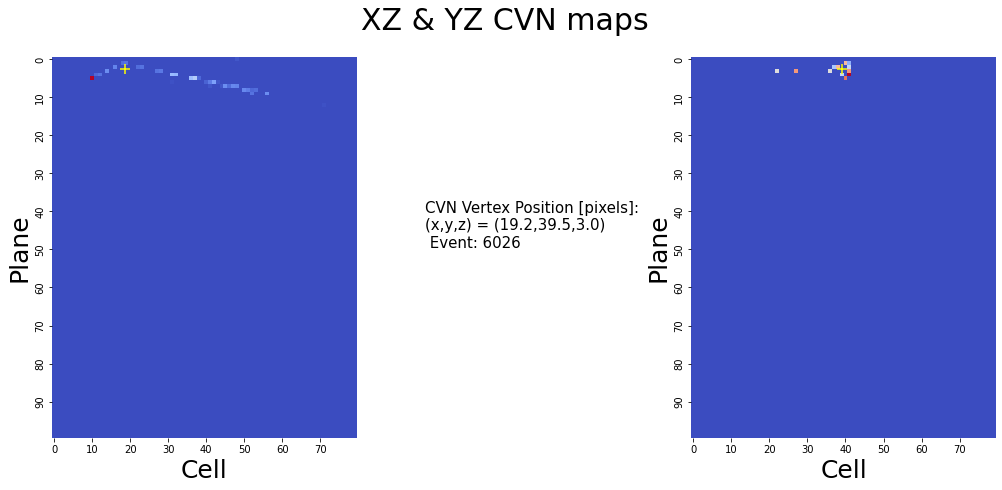

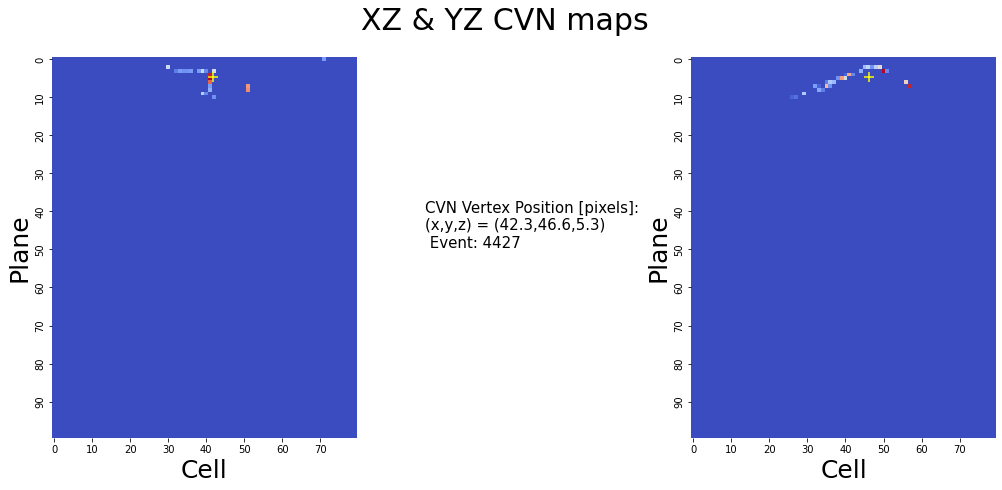

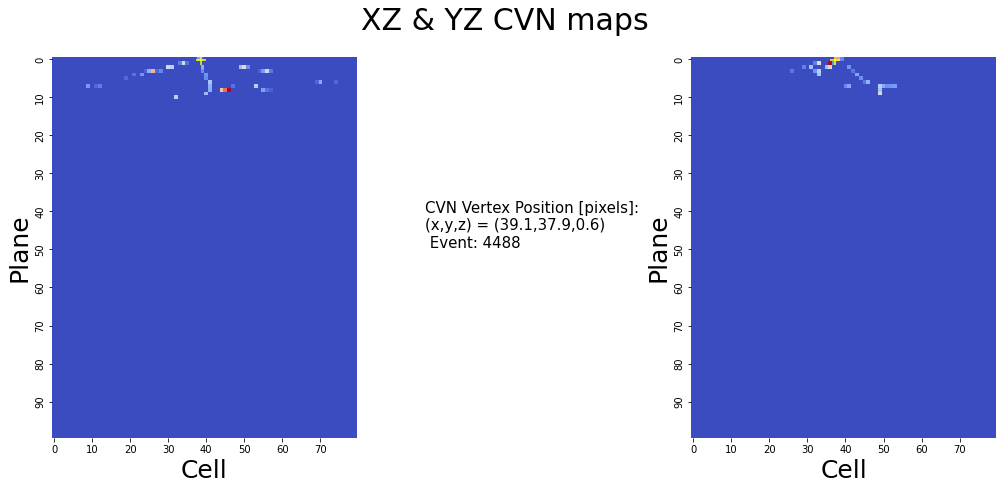

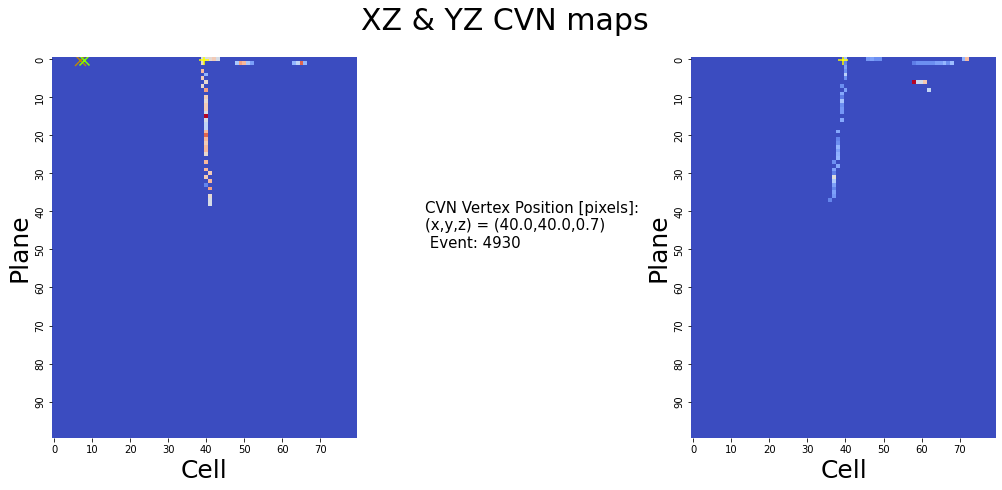

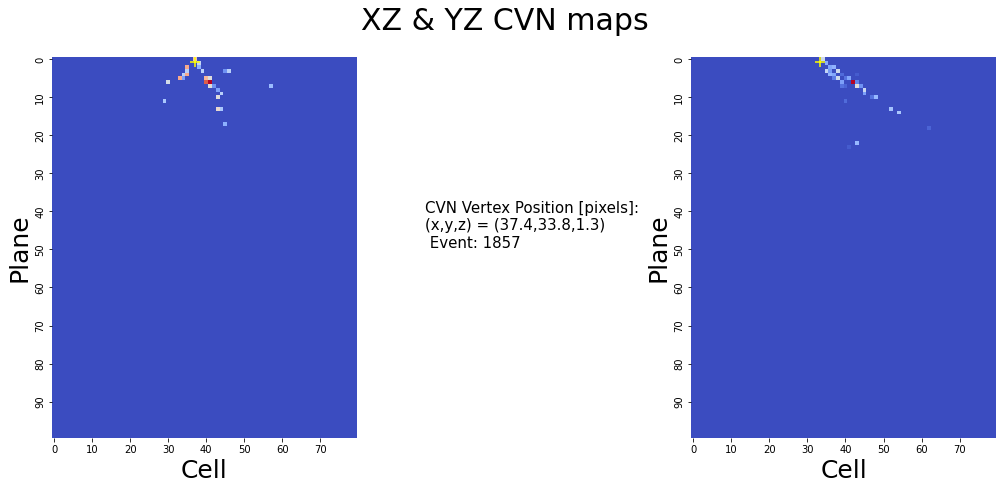

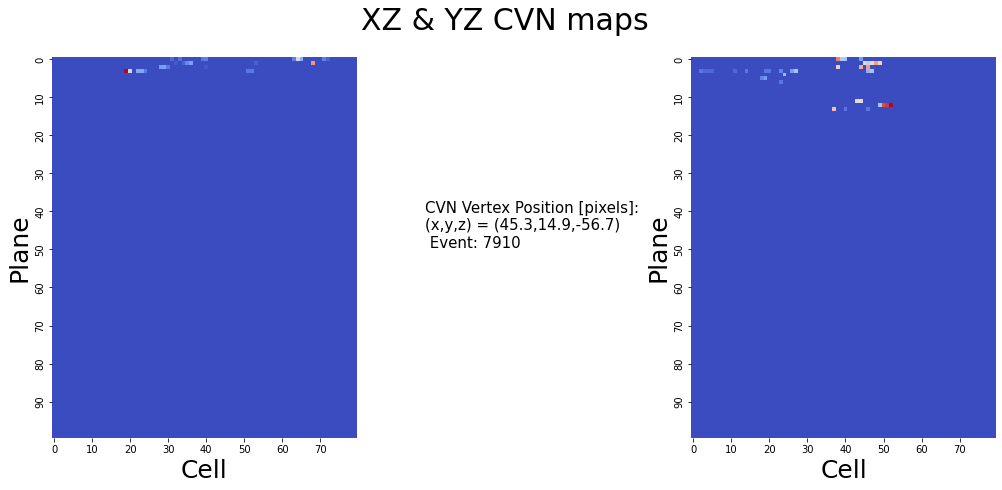

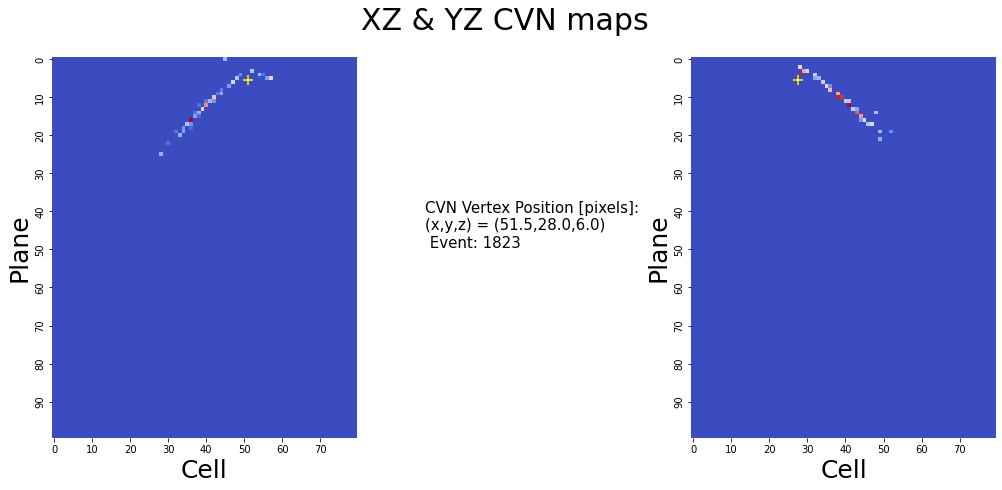

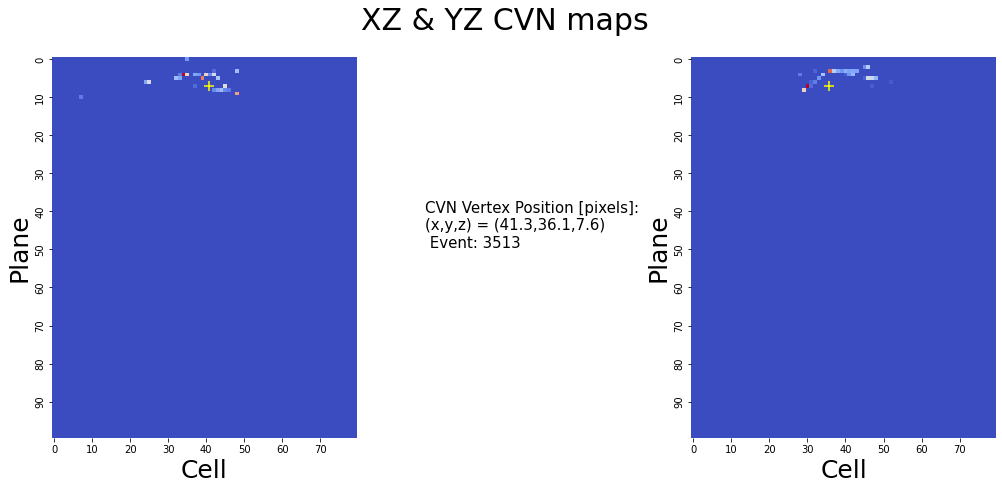

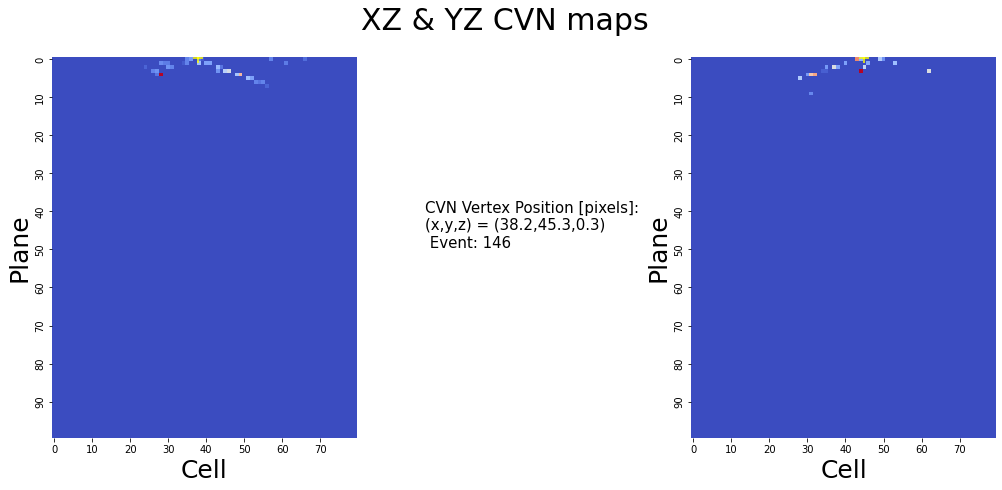

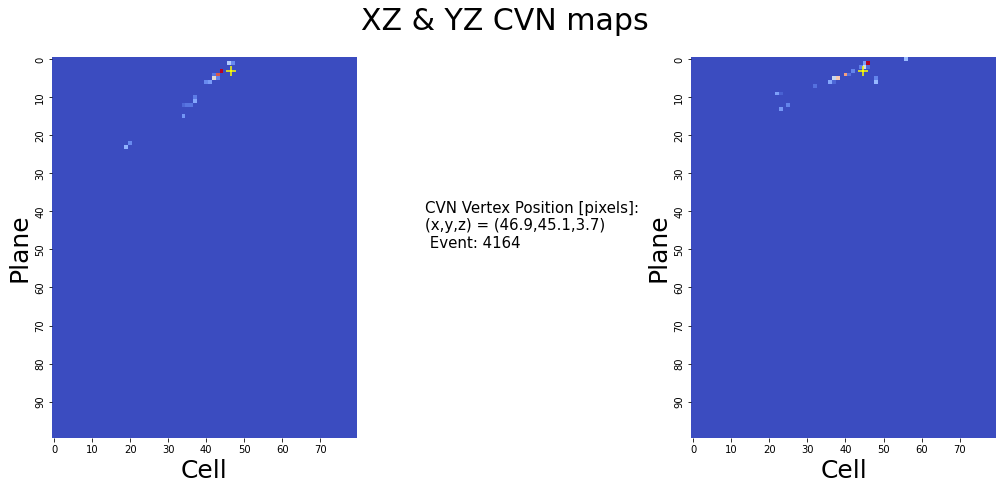

In [15]:
# make a plot of and use random numbers for the event index
for random_event in rndm_array:
# for random_event in [1, 10, 100, 1000, 10000-1]:
    plot_cvnmap_with_vertex(event_idx=random_event, plot_vtx=True, plot_model_pred=True )
    #axes[1].legend()
   

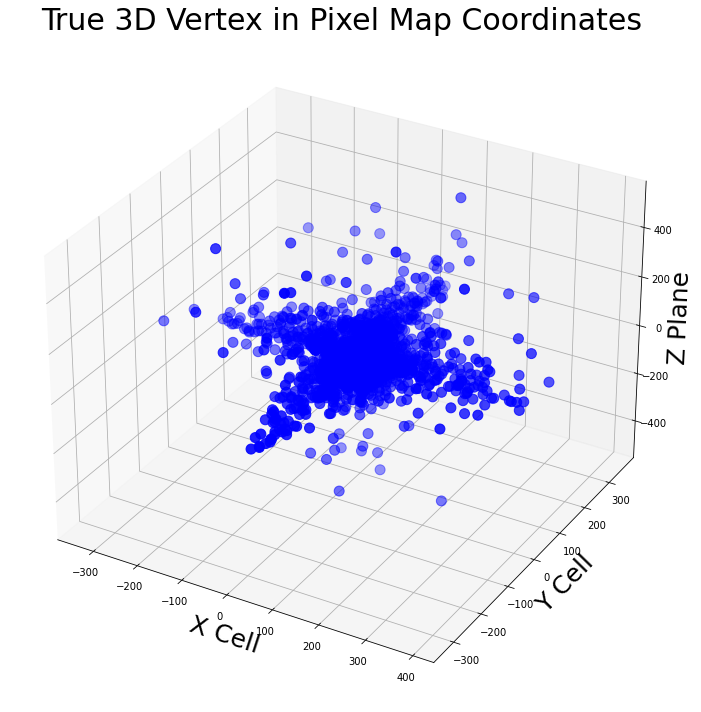

In [16]:
# plot the 3D vertex location in the pixelmap coordinates
plot_3d_vertex_in_cvnmap()

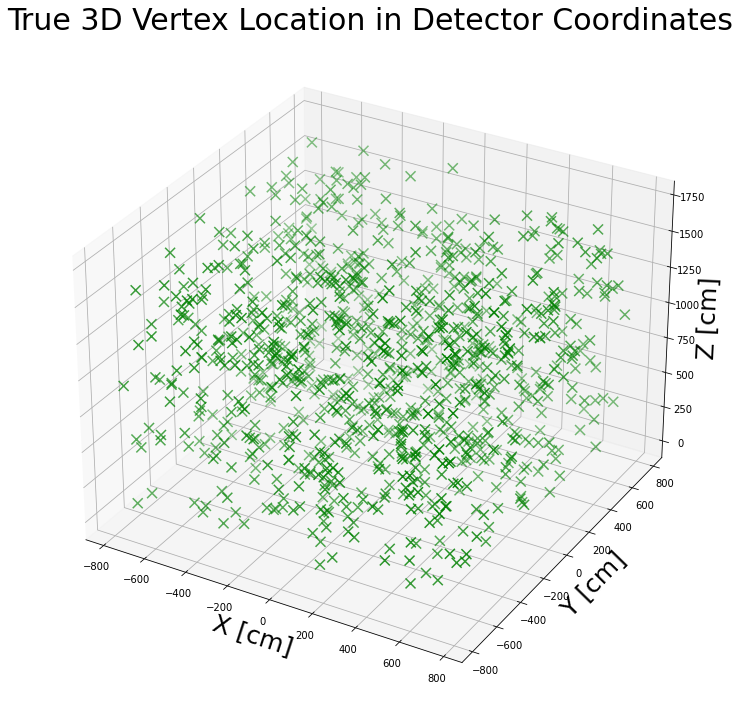

In [17]:
# plot the 3D vertex location in detector coordinates
plot_3d_vertex_location(vertices_to_plot=1000)